## 加载数据集
以MNIST为例,这些数据集是已经有的，在mindspore中基于特殊接口实现了其调用

In [2]:
import mindspore.dataset as ds 
import os
DATA_DIR = "./datasets/MNIST_Data/train"

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
#采样器
sampler = ds.SequentialSampler(num_samples=5)
# dataset = ds.Cifar100Dataset(DATA_DIR,sampler=sampler)
dataset = ds.MnistDataset(DATA_DIR,sampler=sampler) #这个是MNIST数据集

## 迭代数据集
使用 `create_dict_iterator` 创建数据迭代器 迭代访问数据

In [3]:
for data in dataset.create_dict_iterator():
    # print(data)
    print(data['image'].shape)
    print(data['label'])
    

(28, 28, 1)
5
(28, 28, 1)
0
(28, 28, 1)
4
(28, 28, 1)
1
(28, 28, 1)
9


## 自定义数据集
对于mindspore现在不支持直接加载的数据集，可以使用自己构造一个数据集类 然后使用 `GeneratorDataset`接口实现自定义方式的数据加载

In [4]:
import numpy as np
np.random.seed(50)

class GetDatasetGenerator:
    def __init__(self):
        self.data = np.random.sample((5,2))
        self.label = np.random.sample((5,1))
    
    def __getitem__(self,index):
        return self.data[index],self.label[index]
    
    def __len__(self):
        return len(self.data)


init进行初始化
getitem获取索引下的对象
len获取样本数量

使用 `GeneratorDataset` 接口进行加载并访问数据集样本

In [5]:
dataset_generator = GetDatasetGenerator()
dataset1 = ds.GeneratorDataset(dataset_generator,["data","label"],shuffle = False)
print(type(dataset1))
for data in dataset1.create_dict_iterator():
    print(data["data"],data["label"])

<class 'mindspore.dataset.engine.datasets_user_defined.GeneratorDataset'>
[0.49460165 0.2280831 ] [0.3465412]
[0.25547392 0.39632991] [0.35176482]
[0.3773151  0.99657423] [0.14546686]
[0.4081972  0.77189399] [0.97266468]
[0.76053669 0.31000935] [0.90917844]


## 数据处理与数据增强
mindspore提供了数据集接口具备常用的数据处理方法，用户只需调用接口函数即可进行数据处理

下面的样例中先加你个数据集随机打乱顺序，然后将样本两两组成一个批次

In [6]:
ds.config.set_seed(50)

#随机打乱数据顺序
dataset1 = dataset1.shuffle(buffer_size = 4) # buffer_size 数据集中及逆行shuffle缓存区的大小 不可以超过数据集的大小
#对数据进行分批处理
dataset1 = dataset1.batch(batch_size = 2) # 每组包含的数据个数 

for data in  dataset1.create_dict_iterator():
    print("data:{}".format(data["data"]))
    print("label:{}".format(data["label"]))

data:[[0.25547392 0.39632991]
 [0.3773151  0.99657423]]
label:[[0.35176482]
 [0.14546686]]
data:[[0.49460165 0.2280831 ]
 [0.76053669 0.31000935]]
label:[[0.3465412 ]
 [0.90917844]]
data:[[0.4081972  0.77189399]]
label:[[0.97266468]]


## 数据增强
当数据集过小或者样本场景单一等问题，都会影响模型的训练效果

用户可以通过数据增强操作扩充样本多样性，从而提升模型的泛化能力

如下案例中使用`mindspore.dataset.vision.c_transforms`模块中的算子对MNIST数据集进行数据增强

导入c_transforms模块 加载MNIST数据集

(28, 28, 1)


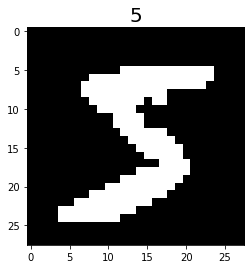

In [9]:
import matplotlib.pyplot as plt
from mindspore.dataset.vision import Inter
import mindspore.dataset.vision.c_transforms as c_vision
DATA_DIR = "./datasets/MNIST_Data/train"
dataset = ds.MnistDataset(DATA_DIR,num_samples=0,shuffle=False)

#查看数据原图
mnist_it = dataset.create_dict_iterator()
data = next(mnist_it)
print(data['image'].shape)
plt.imshow(data['image'].asnumpy().squeeze(),cmap=plt.gray())
plt.title(data['label'].asnumpy(),fontsize = 20 )
plt.show()



定义数据增强算子

对数据进行`resize`和`RandomCrop`操作

通过map映射将其插入 数据处理管道

In [12]:
resize_op = c_vision.Resize(size = (200,200),interpolation=Inter.LINEAR) #Inter 用于插值 线性插值运算
crop_op = c_vision.RandomCrop(150) # 150*150大小的区域crop
transforms_list = [resize_op,crop_op]
mnist_dataset = dataset.map(operations=transforms_list,input_columns=['image'])

(150, 150, 1)


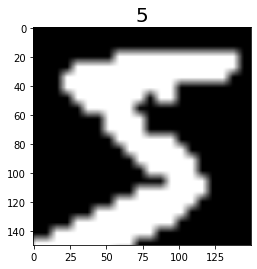

In [13]:
#查看数据增强结果
mnist_it = mnist_dataset.create_dict_iterator()
data = next(mnist_it)
print(data['image'].shape)
plt.imshow(data['image'].asnumpy().squeeze(),cmap=plt.gray())
plt.title(data['label'].asnumpy(),fontsize =20 )
plt.show()